# **Context**

In [1]:
!pip -q install transformers
!pip -q install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, RobertaForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import numpy as np
import pandas as pd

In [3]:
sns.set_style('whitegrid')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Machine_Learning/Projects/fake_news_classifier/fake-news.zip

In [6]:
# Checking if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('GPU is available:', torch.cuda.is_available())

GPU is available: True


In [12]:
# Download the data
df = pd.read_csv('/content/train.csv', index_col='id')

print('Dataframe shape:', df.shape)

Dataframe shape: (20800, 4)


In [13]:
df.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [14]:
print('# of duplicates:', df.duplicated().sum())
df = df.drop_duplicates()

# of duplicates: 109


# **DQA**

In [16]:
# Checking the distribution of labels
print('Distribution of a target variable (absolute):')
print(df.label.value_counts())
print()
print('Distribution of a target variable (percentages):')
print(df.label.value_counts(normalize=True).round(2))

Distribution of a target variable (absolute):
0    10387
1    10304
Name: label, dtype: int64

Distribution of a target variable (percentages):
0    0.5
1    0.5
Name: label, dtype: float64


# **Dealing with missing values**

In [17]:
# Cheking missing values
df.isna().sum()

title      518
author    1932
text        39
label        0
dtype: int64

In [18]:
# Fill in missing values
df.title = df.title.fillna('No title', axis=0)
df.author = df.author.fillna('Unknown', axis=0)
df.text = df.text.fillna('No text', axis=0)

# **Feature engineering**

In [19]:
# Constructing new feature
df['content'] = 'Title:' + df.title + '\nAuthor:' + \
                    df.author + '\nBody:' + df.text

In [20]:
# Leaving essential features
df = df.loc[:, ['content', 'label']]

In [21]:
# Separate features from labels
X = df.drop(columns=['label'], axis=1).content.tolist()
y = df.label.tolist()

# Initialize train, validation and test datasets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)

# **Model initialization**

In [ ]:
# Download the model
model_name = 'xlm-roberta-base'
model = RobertaForSequenceClassification.from_pretrained(model_name)
model = model.to(device)

# Instantiate the tokenizer linked to the Roberta model
tokenizer = AutoTokenizer.from_pretrained(model_name, return_overflowing_tokens=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
# Unfreeze three last layers
layers = ['encoder.layer.10', 'encoder.layer.11', 'classifier']
for layer_name, params in model.named_parameters():
    if any(layer in layer_name for layer in layers):
        params.requires_grad = True
    else:
        params.requires_grad = False

# **Dataloaders building**

In [ ]:
class NewsDataset(Dataset):
    '''
    Dataset class to represent the data in suitable format.
    '''
    def __init__(self, encodings, labels=None, mode='val'):
        super().__init__()

        # Mode
        if mode not in ['train', 'val', 'test']:
            raise ValueError('Invalid mode')
        else:
            self.mode = mode

        # Initializing the data
        self.encodings = encodings
        if mode != 'test':
            self.labels = labels

        # Length of a dataset
        self.len_ = len(self.encodings['input_ids'])

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        if self.mode != 'test':
            # Configuring the output of a dataset
            item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[index])
            return item
        else:
            # Configuring the output of a dataset
            item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
            return item

In [ ]:
def get_dataloader(X, y, tokenizer, mode, max_length=256, batch_size=128):
    '''
    Function to initialize a dataloader.
    '''
    # Encode data
    encodings = tokenizer(X, truncation=True, padding=True, max_length=max_length)

    # Initializing the dataset class instance
    dataset = NewsDataset(encodings, labels=y, mode=mode)

    # Building the dataloader
    if mode == 'train':
        shuffle = True
    else:
        shuffle = False
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [ ]:
# Initialize dataloaders
train_loader = get_dataloader(X_train, y_train, tokenizer, mode='train', max_length=512, batch_size=100)
val_loader = get_dataloader(X_val, y_val, tokenizer, mode='val', max_length=512, batch_size=100)

# **Define fit, eval, train and predict functions**

In [ ]:
def visualize_training(train_history, val_history):
    '''
    Function to visualize the results of a model training.
    '''
    # Plot loss graph
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].set_title('Loss graph')
    ax[0].set_xlabel('Epochs')
    ax[0].plot(train_history['loss'], label='train_loss')
    ax[0].plot(val_history['loss'], label='val_loss')
    ax[0].set_xticks(range(len(train_history['loss'])))

    # Plot accuracy graph
    ax[1].set_title('Accuracy graph')
    ax[1].set_xlabel('Epochs')
    ax[1].plot(train_history['metric'], label='train_accuracy')
    ax[1].plot(val_history['metric'], label='val_accuracy')
    ax[1].set_xticks(range(len(train_history['metric'])))

    ax[0].legend(loc='upper left')
    ax[1].legend(loc='upper left')
    plt.show()

In [ ]:
def fit_epoch(model, loader, criterion, optimizer):
    '''
    Function to train a model on a single epoch.
    '''
    model.train()

    epoch_loss = 0
    epoch_acc = 0

    # Initialize progress bar
    loop = tqdm(loader)

    for batch in loop:
        # Clear gradients
        optimizer.zero_grad()

        # Get encodings, attention masks and labels
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # # Get logits, predictions and loss value
        logits = model(input_ids, attention_mask).logits[:, 1]
        preds = torch.sigmoid(logits) > 0.5
        batch_loss = criterion(logits, labels)

        # Calculate gradients
        batch_loss.backward()

        # Clip the gradients to prevent "exploding" gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Make backprop step
        optimizer.step()

        # Calculate accuracy
        batch_correct = (preds == labels).sum()
        batch_acc = batch_correct / len(labels)

        # Update training history
        epoch_loss += batch_loss / len(loader)
        epoch_acc += batch_acc / len(loader)

        # Update progress bar
        loop.set_postfix(batch_loss=torch.round(batch_loss, decimals=3).item(),
                         batch_acc=torch.round(batch_acc, decimals=3).item())
    return epoch_loss.item(), epoch_acc.item()

In [ ]:
def eval_epoch(model, loader, criterion, optimizer):
    '''
    Function to evaluate performance of a model on a validation dataset.
    '''
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    for batch in loader:
        # Get encodings, attention masks and labels
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            # Get logits, predictions and loss value
            logits = model(input_ids, attention_mask).logits[:, 1]
            preds = torch.sigmoid(logits) > 0.5
            batch_loss = criterion(logits, labels)

        # Calculate accuracy
        batch_correct = (preds == labels).sum()
        batch_acc = batch_correct / len(labels)

        # Update validation history
        epoch_loss += batch_loss / len(loader)
        epoch_acc += batch_acc / len(loader)
    return epoch_loss.item(), epoch_acc.item()

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer,
          scheduler=None, epochs=5):
    '''
    Function to train a model and save the best one.
    '''
    # History tracking initialization
    train_history = {'loss': [], 'metric': []}
    val_history = {'loss': [], 'metric': []}

    # Initial values for best model selection
    best_model = model.state_dict()
    best_acc = 0.0

    # Early stoppage criterion initialization
    count = 0

    for epoch in range(epochs):
        print('Epoch:', epoch)

        # Restarting the trigger
        best_model_updated = False

        # Training part of epoch
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
        train_history['loss'].append(train_loss)
        train_history['metric'].append(train_acc)

        # Validation part of epoch
        val_loss, val_acc = eval_epoch(model, val_loader, criterion, optimizer)
        val_history['loss'].append(val_loss)
        val_history['metric'].append(val_acc)

        # Scheduler step (optiomal)
        if scheduler != None:
            scheduler.step()

        # Early stoppage criterion check and best model update
        if val_acc <= best_acc:
            count += 1
            if count >= 2:
                break
        else:
            # Refresh early stoppage criterion
            count = 0

            # Update the best model
            best_model = model.state_dict()
            best_acc = val_acc
            best_model_updated = True

        # Visualization of training process
        clear_output(wait=True)
        print('Epoch:', epoch)
        print('Train loss:', np.round(train_loss, decimals=3))
        print('Train accuracy:', np.round(train_acc, decimals=3))
        print('Validation loss:', np.round(val_loss, decimals=3))
        print('Validation accuracy:', np.round(val_acc, decimals=3))
        print('Best model updated:', best_model_updated)
        visualize_training(train_history, val_history)
    return train_history, val_history, best_model

In [ ]:
def predict(model, loader):
    '''
    Function to make predictions.
    '''
    model.eval()

    predictions = []

    for batch in loader:
        # Get encodings and attention masks
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        with torch.no_grad():
            # Get logits and predictions
            logits = model(input_ids, attention_mask).logits[:, 1]
            predictions += list((torch.sigmoid(logits) > 0.5).cpu().numpy().astype(int))
    return predictions

# **Finetune the model**

In [ ]:
# Initializing training parameters
epochs=8
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.BCEWithLogitsLoss()

Epoch: 4
Train loss: 0.002
Train accuracy: 0.999
Validation loss: 0.0
Validation accuracy: 1.0
Best model updated: True


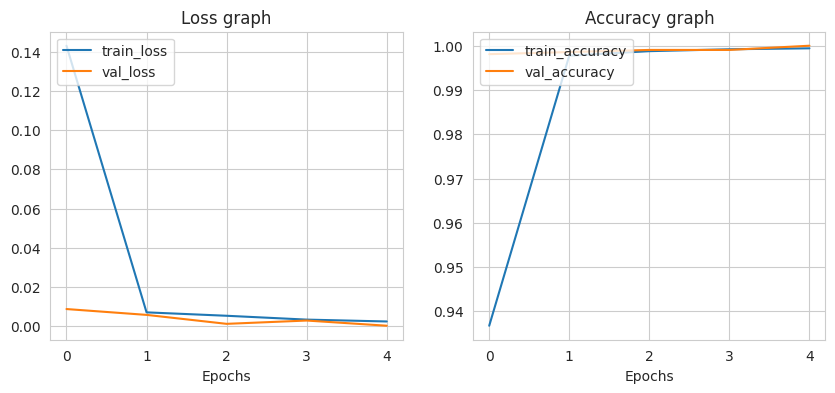

Epoch: 5


 86%|████████▌ | 161/187 [11:36<01:52,  4.31s/it, batch_acc=1, batch_loss=0]

In [ ]:
# Training the model
train_history, val_history, best_model = train(model, train_loader, val_loader,
                                               criterion, optimizer, epochs=epochs)

In [ ]:
# Save the model
torch.save(best_model, f'/content/drive/MyDrive/Machine_Learning/Projects/task_10_text_classification/ROBERTA.pt')

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()